**PROYECTO 3**


**AUTORES**: 

             Oscar Fallas B92861

             Daniel Chacon B72018
             
             Alejandro Castillo B81787
                                                                                            



**Librerías utilizadas**



In [1]:
import random 
import numpy as np
import binascii
import matplotlib.pyplot as plt


**Fuente**

Simulación de fuente del sistema.


In [2]:
M = 4 

def random_sequence(length):
    zeros = length // 2
    ones = length - zeros 
    sequence = [0] * zeros + [1] * ones
    random.shuffle(sequence)
    bf = ''.join(str(bit) for bit in sequence)
    return bf


def source_coder(text_in):
    #Read from txt
    with open(text_in, "r") as file:
        cadena = file.read()
        print("El mensaje es:",cadena)
    #Coding the text read
        coder = bin(int(binascii.hexlify(cadena.encode()), 16))
        # La salida tiene "0b" como formato 
        out = coder
        print("El mensaje codificado con formato de impresión binaria: ", out)
        # Mensaje binario limpio
        out_clean = out.replace('b','')
        print("El mensaje codificado es: ", out_clean)

    return out_clean

**Codificador de canal**

Codifica mensaje que recibe de la fuente.


In [3]:
def channel_encoder(sequence):
    #Separo bf en vectores de 4 bits para utilizar Hamming 7x4

    sequence_length = len(sequence)//4
    u_vector = []

    for i in range(sequence_length):
        start = i * 4
        end = start + 4
        u = sequence[start:end]
        u_vector.append(u)

    #Matriz G (7x4)

    G = np.array([
    [1, 0, 0, 0, 1, 0, 1],
    [0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 1]
    ])

    v_vector = []
    for u in u_vector:
        u_bits = np.array(list(u)).astype(int)
        #print(u_bits)
        v_bits = np.dot(u_bits, G) % 2
        #print(v_bits)
        v = ''.join(str(bit) for bit in v_bits)
        v_vector.append(v)

    bc = ''.join(v_vector) 
    return bc

def ideal_transmition_channel(bc):
    bc_prima = bc
    return bc_prima

def simetric_binary_channel(bc):
    prob = 0.001

    bc_prima = ''
    for bit in bc:
        ran_num = random.random()

        if ran_num < (1-prob):
            e_bit = bit
        else:
            e_bit = 1 - int(bit)

        bc_prima += str(e_bit)

    return bc_prima

def simetric_binary_channel_user(bc, prob):
    #prob = (int(input("Indique probabilidad de error: "))/100)    
    bc_prima = ''
    for bit in bc:
        ran_num = random.random()

        if ran_num < (1-prob):
            e_bit = bit
        else:
            e_bit = 1 - int(bit)

        bc_prima += str(e_bit)

    return bc_prima

**Modulación PAM**


In [4]:
def modulacionPAM(bc):
    # Verificar que la longitud de la secuencia de bits bc(ℓ) sea múltiplo de log2(M)
    b = int(np.log2(M))
    if len(bc) % b != 0:
        # Rellenar con ceros si no es múltiplo
        bc = np.concatenate([bc, np.zeros(b - len(bc) % b)])

    # Dividir la secuencia de bits en grupos de M
    grupos = [bc[i:i+int(np.log2(M))] for i in range(0, len(bc), int(np.log2(M)))]
    #print(grupos)

    # Diccionario de asignación de símbolos de amplitud
    simbolos = {
        (0, 0): -1,
        (0, 1): -1/3,
        (1, 0): 1,
        (1, 1): 1/3
        }
    
    #Señal Modulada 
    x_k = []
    for señal in grupos:
        t_señal = tuple(señal)
        simbolo = simbolos[tuple(t_señal)]
        x_k.append(simbolo)
    x_k = np.array(x_k)

    #Definimos el tren de pulsos de amplitud 1 y longitud 20
    t = np.arange(0,len(x_k),1)
    p = np.ones_like(t)
    #print(t)
    x_k = x_k*p
    #print(x_k)

    # Graficar el tren de pulsos
    plt.stem(t, x_k, linefmt='b-', markerfmt='bo', basefmt='r-')

    # Configurar etiquetas y título del gráfico
    plt.xlabel('Tiempo')
    plt.ylabel('Amplitud')
    plt.title('MODULACIÓN PAM')

    # Ajustar los límites del eje y
    plt.ylim(-1.5, 1.5)
    plt.show()

    return x_k

**Modulación ASK**


In [5]:
def modulacionASK(bc, fc, Ts):
    #Modulacion Banda Base
    # Verificar que la longitud de la secuencia de bits bc(ℓ) sea múltiplo de log2(M)
    b = int(np.log2(M))
    if len(bc) % b != 0:
        # Rellenar con ceros si no es múltiplo
        bc = np.concatenate([bc, np.zeros(b - len(bc) % b)])

    # Dividir la secuencia de bits en grupos de M
    grupos = [bc[i:i+int(np.log2(M))] for i in range(0, len(bc), int(np.log2(M)))]

    # Diccionario de asignación de símbolos de amplitud
    simbolos = {
        (0, 0): -1,
        (0, 1): -1/3,
        (1, 0): 1,
        (1, 1): 1/3
        }

    # Secuencia de símbolos a(n)
    an = [simbolos[tuple(grupo)] for grupo in grupos]

    #Modulacion paso banda ASK 

    # Secuencia de muestras c(k)
    Ns = int(Ts * fc)
    t = np.arange(0, Ns)
    c = np.cos(2 * np.pi * fc * t / Ns)

    # Secuencia de señal modulada sn(k)
    sn = np.kron(an, c)

    # Graficar la señal modulada
    t = np.linspace(0, len(sn) / fc, len(sn))
    plt.plot(t, sn)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('Señal Modulada ASK')
    plt.grid(True)
    plt.show()

    return sn


**Ruido gaussiano**

In [6]:
def add_noise(x, snr):
    # Calcular la potencia de la señal transmitida
    signal_power = np.mean(np.abs(x) ** 2)

    # Calcular la potencia del ruido en función de la relación señal-ruido (SNR)
    noise_power = signal_power / (10 ** (snr / 10))

    # Generar el ruido gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(x))

    # Sumar el ruido a la señal transmitida
    x_r = x + noise

    return x_r

**Demodulador PAM**

In [7]:
def demodulacionPAM(x_k):
    # Diccionario inverso de asignación de símbolos de amplitud
    simbolos_inversos = {
        -1: (0, 0),
        -1/3: (0, 1),
        1: (1, 0),
        1/3: (1, 1)
    }
    
    # Lista para almacenar la secuencia de bits demodulada
    bits_demodulados = []
    
    # Obtener la longitud original de la secuencia de bits
    longitud_original = len(x_k) * int(np.log2(M))
    
    # Iterar sobre cada símbolo de amplitud en la secuencia modulada
    for simbolo in x_k:
        # Buscar el símbolo de amplitud correspondiente en el diccionario inverso
        bits = simbolos_inversos[simbolo]
        
        # Agregar los bits a la secuencia demodulada
        bits_demodulados.extend(bits)
    
    # Verificar si se agregaron ceros durante la modulación
    diferencia = len(bits_demodulados) - longitud_original
    if diferencia > 0:
        # Eliminar los ceros adicionales
        bits_demodulados = bits_demodulados[:-diferencia]
    
    # Convertir la lista de bits demodulados en un array numpy
    bits_demodulados = np.array(bits_demodulados)
    
    return bits_demodulados


**Demodulador ASK**

In [8]:
def demodulador_ASK(sn, fc, Ts):
    # Número de niveles de amplitud en la modulación ASK
    M = 4

    # Umbrales para la detección de amplitud
    umbrales = [-1.5, -0.5, 0.5, 1.5]

    # Número de muestras por símbolo
    Ns = int(Ts * fc)

    # Número de símbolos en la señal modulada
    num_simbolos = len(sn) // Ns

    # Inicializar la secuencia de bits de salida
    bits_recibidos = []

    # Procesar cada símbolo
    for i in range(num_simbolos):
        # Obtener una muestra del símbolo
        muestra_simbolo = sn[i * Ns: (i + 1) * Ns]

        # Calcular el promedio de la muestra del símbolo
        promedio_muestra = np.mean(muestra_simbolo)

        # Encontrar el índice del umbral más cercano al promedio de la muestra
        indice_umbral = min(range(len(umbrales)), key=lambda x: abs(umbrales[x] - promedio_muestra))

        # Convertir el índice del umbral en la secuencia de bits del símbolo
        bits_simbolo = [int(bit) for bit in np.binary_repr(indice_umbral, width=int(np.log2(M)))]

        # Agregar la secuencia de bits del símbolo a la secuencia de bits recibidos
        bits_recibidos.extend(bits_simbolo)

    # Verificar si se agregaron ceros adicionales durante la modulación
    diferencia = len(bits_recibidos) % int(np.log2(M))
    if diferencia > 0:
        # Eliminar los ceros adicionales
        bits_recibidos = bits_recibidos[:-diferencia]

    return np.array(bits_recibidos)


**Decodificador de canal**

In [9]:
def channel_decoder(bc_prima):
    # Matriz H (3x7) - Para detección y corrección de errores
    H = np.array([
        [1, 0, 0, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1]
    ])

    #Calculo de sindrome de paridad 
    bc_prima_length = len(bc_prima)//7
    v_prima_vector = []

    for i in range(bc_prima_length):
        start = i * 7
        end = start + 7
        u = bc_prima[start:end]
        v_prima_vector.append(u)

    v_prima_vector = np.array([[int(bit) for bit in bits] for bits in v_prima_vector])
    
    corrected_v_prima = []
    for v in v_prima_vector:
        a0 = v[0]
        a1 = v[1]
        a2 = v[2]
        a3 = v[3]
        p0 = v[4]
        p1 = v[5]
        p2 = v[6]

        s0 = p0+a0+a1+a2
        s1 = p1+a1+a2+a3
        s2 = p2+a0+a1+a3
        S = [s0, s1, s2]
        #v_t = np.transpose(v)
        #S = np.dot(H,v_t)
        #print(S)
        S = np.remainder(S, 2)
        S = ''.join([str(bit) for bit in S])
        print("Antes correcion: ",v)
        print("sindrome:" ,S)
        print(v[0])

        #Deteccion de error y correccion
        if (S == '001'):
            v[6] = 1 - v[6]
        elif(S == '010'): 
            v[5] = 1 - v[5]
        elif(S == '011'): 
            v[3] = 1 - v[3]
        elif(S == '100'): 
            v[4] = 1 - v[4]
        elif(S == '101'): 
            v[0] = 1 - v[0]
        elif(S == '110'): 
            v[2] = 1 - v[2]
        elif(S == '111'): 
            v[1] = 1 - v[1]

        print("Despues correcion: ",v)

        corrected_v_prima.append(v)

    bfR = ''.join([str(bit) for bits in corrected_v_prima for bit in bits[:4]])
    return bfR


**Decodificador de fuente**

In [10]:

def source_decoder(bfT, text_out):
    decode = int(bfT, 2)
    print(decode)
    text = decode.to_bytes((decode.bit_length() + 7) // 8, 'big').decode()


    with open(text_out, 'w') as file: 
        file.write(text)

    with open(text_out, "r") as file:
            cadena_sumidero = file.read()
    
    print("El mensaje luego del proceso de decodificación de canal y fuente es: ", cadena_sumidero)


**Menús**

In [11]:
def opcion_1():


    print("Ha seleccionado la codificación de canal")
    print("Menú de opciones:")
    print("1. Opción 1: Codificación de canal ideal")
    print("2. Opción 2: Codificación de canal simétrico binario")
    opcion_seleccionada_canal = int(input("Seleccione una opción: "))

    if opcion_seleccionada_canal==1:
        # Se selecciona canal ideal
        opcion_1_1()
    else:
        opcion_1_2()



# En caso de escogerse codificación de canal, la opción_1_1 es canal ideal
def opcion_1_1():


    print("Ha seleccionado la opción de codificación de canal ideal")
    
    sequence = random_sequence(32)

    bc = channel_encoder(sequence)
    print(bc)
    # Llamado a función de canal ideal
    bc_prima = ideal_transmition_channel(bc)
    print(bc_prima)


    bfT = channel_decoder(bc_prima)
    print("Secuencia enviada: ", sequence)
    print("Secuencia recibida: ", bfT)

    num_bits = len(bc)
    num_bits_diferentes = sum(bit1 != bit2 for bit1, bit2 in zip(bc, bc_prima))
    porcentaje_error = (num_bits_diferentes / num_bits) * 100
    print("% antes de correccion de errores",porcentaje_error)
    num_bits2 = len(sequence)
    num_bits_diferentes2 = sum(bit3 != bit4 for bit3, bit4 in zip(sequence, bfT))
    porcentaje_error2 = (num_bits_diferentes2 / num_bits2) * 100
    print("% despues de correccion de errores",porcentaje_error2)  

# En caso de escogerse codificación de canal, la opción_1_2 es canal simétrico
def opcion_1_2():
    print("Ha seleccionado la opción de codificación de canal simétrico binario")
    # El usuario ingresa probabilidad de error deseada
    entrada = int(input("Indique probabilidad de error: "))
    prob=entrada/100

    sequence = random_sequence(32)

    bc = channel_encoder(sequence)
    print(bc)

    # Llamado a función de canal ideal
    bc_prima = simetric_binary_channel_user(bc,prob)
    print(bc_prima)


    bfT = channel_decoder(bc_prima)
    print("Secuencia enviada: ", sequence)
    print("Secuencia recibida: ", bfT)

    num_bits = len(bc)
    num_bits_diferentes = sum(bit1 != bit2 for bit1, bit2 in zip(bc, bc_prima))
    porcentaje_error = (num_bits_diferentes / num_bits) * 100
    print("% antes de correccion de errores",porcentaje_error)
    num_bits2 = len(sequence)
    num_bits_diferentes2 = sum(bit3 != bit4 for bit3, bit4 in zip(sequence, bfT))
    porcentaje_error2 = (num_bits_diferentes2 / num_bits2) * 100
    print("% despues de correccion de errores",porcentaje_error2) 

def opcion_2():
    print("Ha seleccionado la opción 2")
    
    text_in = 'fuente.txt'
    text_out = 'sumidero.txt'


    sequence = source_coder(text_in)
    bc = channel_encoder(sequence)
    bc_prima = simetric_binary_channel(bc)
    bfT = channel_decoder(bc_prima)

    print("Secuencia enviada: ", sequence)
    print("Secuencia recibida: ", bfT)


    num_bits = len(bc)
    num_bits_diferentes = sum(bit1 != bit2 for bit1, bit2 in zip(bc, bc_prima))
    porcentaje_error = (num_bits_diferentes / num_bits) * 100
    print("% antes de correccion de errores",porcentaje_error)
    num_bits2 = len(sequence)
    num_bits_diferentes2 = sum(bit3 != bit4 for bit3, bit4 in zip(sequence, bfT))
    porcentaje_error2 = (num_bits_diferentes2 / num_bits2) * 100
    print("% despues de correccion de errores",porcentaje_error2)


    source_decoder(bfT, text_out)


def opcion_3():

    print("Ha seleccionado la opción 3")
    # El usuario ingresa probabilidad de error deseada
    entrada = int(input("Indique probabilidad de error: "))
    prob=entrada/100

    text_in = 'fuente.txt'
    text_out = 'sumidero.txt'


    sequence = source_coder(text_in)
    bc = channel_encoder(sequence)
    bc_prima = simetric_binary_channel_user(bc, prob)
    lista_1 = []

    for caracter in bc_prima:
        lista_1.append(caracter)
    #print(lista)

    arreglo = np.array(lista_1).astype(int)
    #print(arreglo)


    x_k = modulacionPAM(arreglo)
    x_R = add_noise(x_k, 10)
    x_bc = demodulacionPAM(x_k)

    cadena_bits = ''.join(str(bit) for bit in x_bc)
    print(cadena_bits)

    bfT = channel_decoder(cadena_bits)
    bfT1=bfT


    print("Secuencia enviada: ", sequence)
    print("La secuencia modulada x(k): ", x_k)
    print("Secuencia con ruido: ", x_R)
    print("La secuencia demodulada es: ", cadena_bits)
    
    print("Secuencia recibida: ", bfT1)


    source_decoder(bfT1, text_out)

def opcion_4():

    print("Ha seleccionado la opción 4")
    # El usuario ingresa probabilidad de error deseada
    entrada = int(input("Indique probabilidad de error para el canal simetrico binario: "))
    prob=entrada/100

    text_in = 'fuente.txt'
    text_out = 'sumidero.txt'


    sequence = source_coder(text_in)
    bc = channel_encoder(sequence)
    bc_prima = simetric_binary_channel_user(bc, prob)
    #print(bc_prima)
    lista_1 = []

    for caracter in bc_prima:
        lista_1.append(caracter)
    #print(lista)

    arreglo = np.array(lista_1).astype(int)
    #print(arreglo)

    fc = 10e3  # Frecuencia de la portadora (10 kHz)
    Ts = 1e-3  # Duración de la señal c(t) (1 ms)


    s_k = modulacionASK(arreglo, fc, Ts)

    #Realizar cambios aleatorios en las muestras transmitidas
    #N = np.random.normal(0, 1, len(s_k))
    #s_R = s_k + N
    s_R = add_noise(s_k, 30)
    bc_R = demodulador_ASK(s_k, fc, Ts)

    bc_R = ''.join(str(bit) for bit in bc_R)

    bfT = channel_decoder(bc_R)
    bfT1=bfT


    print("Secuencia enviada: ", sequence)
    print("La secuencia modulada x(k): ", s_k)
    print("Secuencia con ruido: ", s_R)
    print("La secuencia demodulada es: ", bc_R)
    
    print("Secuencia recibida: ", bfT1)


    source_decoder(bfT1, text_out)
    


def opcion_predeterminada():
    print("Opción inválida")

def salir():
    print("Saliendo del programa.")

# Menú de casos
def menu(opcion):
    switch = {
        1: opcion_1,
        2: opcion_2,
        3: opcion_3,
        4: opcion_4
    }
    # Obtener la función correspondiente a la opción seleccionada
    funcion = switch.get(opcion, opcion_predeterminada)
    # Ejecutar la función
    funcion()

    imprimir_menu()

**Proyecto Integrado**

En la siguiente sección se procede a conectar los componentes de modulación y demodulación con las partes anteriormente realizadas(codificador de fuente, codificador de canal) con el fin de comprobar su correcto funcionamiento. Para estoy dirigase al archivo proyecto_integrado.py, este se le realizó una interfaz interactiva para que el usuario escoja que elementos quiere probar:

                                                                                                    --opcion 1--: codificación canal 
                                                                                                    --opcion 2--: cofificación de fuente y canal
                                                                                                    --opcion 3--: codificación de fuente, canal y modulacion banda base

Tambien, en el código abajo note que se exporta el archivo por lo que puede utilizarlo desde aquí. Además, el código despliega toda la información necesaria para ir demostrando que se cumple satisfactoriamente el proceso de comunicación. 


Menú de opciones:
0. Salir
1. Opción 1: Codificación de canal
2. Opción 2: Codificación de fuente y canal
3. Opción 3: Codificación de fuente, canal y modulación banda base
4. Opción 4: Codificación de fuente, canal y modulación paso banda
Ha seleccionado la opción 3
El mensaje es: Emergencia se queman los frijoles
El mensaje codificado con formato de impresión binaria:  0b10001010110110101100101011100100110011101100101011011100110001101101001011000010010000001110011011001010010000001110001011101010110010101101101011000010110111000100000011011000110111101110011001000000110011001110010011010010110101001101111011011000110010101110011
El mensaje codificado es:  010001010110110101100101011100100110011101100101011011100110001101101001011000010010000001110011011001010010000001110001011101010110010101101101011000010110111000100000011011000110111101110011001000000110011001110010011010010110101001101111011011000110010101110011


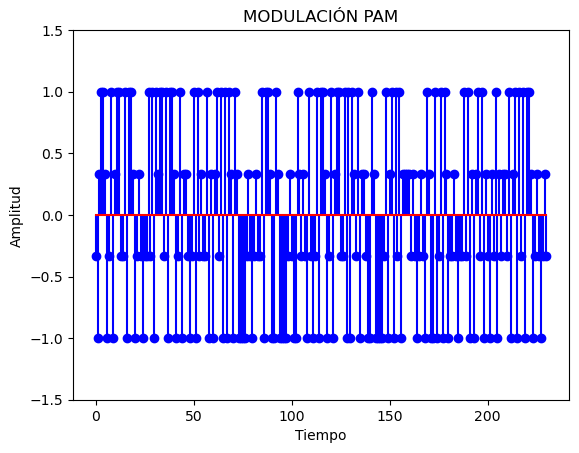

010011101011000110001110100101100010101100011101000101100110001011101001100010101100011000111101000110001001110101100011001110011000100010110010110000000001110100011101011000101011000010110000000001110100001011011101001001000110001010110001100011101001011000100010110110001111010000101100000000011000111000100110001111111101110100011101001011000010000110001011000101110100010110011000110011100110001101001101100011011111011000111000100110001010110001110100011101
Antes correcion:  [0 1 0 0 1 1 1]
sindrome: 000
0
Despues correcion:  [0 1 0 0 1 1 1]
Antes correcion:  [0 1 0 1 1 0 0]
sindrome: 000
0
Despues correcion:  [0 1 0 1 1 0 0]
Antes correcion:  [0 1 1 0 0 0 1]
sindrome: 000
0
Despues correcion:  [0 1 1 0 0 0 1]
Antes correcion:  [1 1 0 1 0 0 1]
sindrome: 000
1
Despues correcion:  [1 1 0 1 0 0 1]
Antes correcion:  [0 1 1 0 0 0 1]
sindrome: 000
0
Despues correcion:  [0 1 1 0 0 0 1]
Antes correcion:  [0 1 0 1 1 0 0]
sindrome: 000
0
Despues correcion:  [0 1 0 1 1 0 0]
Antes correcion:  [0 

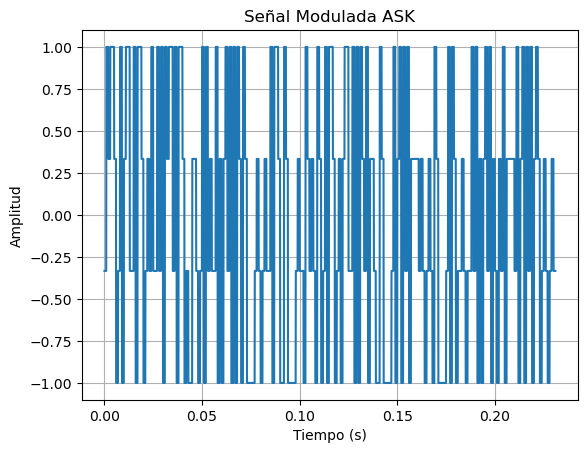

Antes correcion:  [0 1 1 0 1 0 1]
sindrome: 100
0
Despues correcion:  [0 1 1 0 0 0 1]
Antes correcion:  [0 1 0 1 0 0 0]
sindrome: 100
0
Despues correcion:  [0 1 0 1 1 0 0]
Antes correcion:  [0 1 1 0 0 0 1]
sindrome: 000
0
Despues correcion:  [0 1 1 0 0 0 1]
Antes correcion:  [0 1 0 1 0 0 1]
sindrome: 101
0
Despues correcion:  [1 1 0 1 0 0 1]
Antes correcion:  [0 1 1 0 0 0 1]
sindrome: 000
0
Despues correcion:  [0 1 1 0 0 0 1]
Antes correcion:  [0 1 0 1 0 0 0]
sindrome: 100
0
Despues correcion:  [0 1 0 1 1 0 0]
Antes correcion:  [0 1 1 0 0 1 1]
sindrome: 010
0
Despues correcion:  [0 1 1 0 0 0 1]
Antes correcion:  [0 0 1 0 1 1 0]
sindrome: 000
0
Despues correcion:  [0 0 1 0 1 1 0]
Antes correcion:  [0 1 1 0 0 0 1]
sindrome: 000
0
Despues correcion:  [0 1 1 0 0 0 1]
Antes correcion:  [0 1 0 1 0 1 0]
sindrome: 110
0
Despues correcion:  [0 1 1 1 0 1 0]
Antes correcion:  [0 1 1 0 0 0 1]
sindrome: 000
0
Despues correcion:  [0 1 1 0 0 0 1]
Antes correcion:  [0 1 0 1 0 0 0]
sindrome: 100
0
Desp

ValueError: invalid literal for int() with base 10: ''

In [13]:
def imprimir_menu():
    print("\nMenú de opciones:")
    print("0. Salir")
    print("1. Opción 1: Codificación de canal")
    print("2. Opción 2: Codificación de fuente y canal")
    print("3. Opción 3: Codificación de fuente, canal y modulación banda base")
    print("4. Opción 4: Codificación de fuente, canal y modulación paso banda")


imprimir_menu()

while True:
    opcion_seleccionada = int(input("Seleccione una opción: "))
    if opcion_seleccionada == 0:
        salir()
        break
    else:
        menu(opcion_seleccionada)